## Домашнее задание

Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **

### Установка BigARTM
Все точно как в инструкции на их сайте, только без установки питона и пипа.

In [ ]:
!apt-get --yes install git make cmake build-essential libboost-all-dev

In [ ]:
!pip install protobuf tqdm wheel

In [ ]:
!git clone --branch=stable https://github.com/bigartm/bigartm.git

In [4]:
cd bigartm

/content/bigartm


In [5]:
mkdir build

In [7]:
cd build

[Errno 2] No such file or directory: 'build'
/content/bigartm/build


In [ ]:
!cmake ..

In [ ]:
!make

In [ ]:
!pip install python/bigartm*.whl -U

Вернемся в изначальную папку.

In [11]:
cd ../.. 

/content


In [ ]:
!pip install pymorphy2[fast] nltk gensim

In [ ]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import string
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stops = set(stopwords.words('russian'))

## Предобработка

In [27]:
def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = re.findall(r"[а-яА-ЯёЁ]+-*[а-яА-ЯёЁ]*", text)
    return words

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/wiki_data.txt.zip

In [16]:
!unzip wiki_data.txt.zip

Archive:  wiki_data.txt.zip
  inflating: wiki_data.txt           
  inflating: __MACOSX/._wiki_data.txt  


In [31]:
texts = open('wiki_data.txt').read().splitlines()
texts = opt_normalize([tokenize(text.lower()) for text in texts], 25000)

#### Порог PMI подобран экспериментально, составляет 0.4

In [49]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4, \
                           common_terms=set(stopwords.words('russian')))
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

In [51]:
f = open('wiki_texts.vw', 'w')

for i, text in enumerate(ngrammed_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()



In [53]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()
    

In [54]:
batch_vectorizer = artm.BatchVectorizer(data_path='wiki_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

In [55]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

## Генерация словаря

In [56]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

#### Снизим минимальный и максимальный пороги частотностей, рассмотрим результаты

In [58]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=5, max_df=1800)

artm.Dictionary(name=ad459260-a033-4b0b-87d8-fde2424b957d, num_entries=16822)

In [59]:
dictionary.save_text('dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

In [63]:
!head -n 15 dict.txt

name: ad459260-a033-4b0b-87d8-fde2424b957d num_items: 20002
token, class_id, token_value, token_tf, token_df
лихтенштейн_зимний, @default_class, 5.9329399846319575e-06, 14.0, 14.0
сезон_отчаянный, @default_class, 2.5426886622881284e-06, 6.0, 6.0
кувейт_принимать, @default_class, 4.237814209773205e-06, 10.0, 10.0
тобаго_принимать, @default_class, 7.204284429462859e-06, 17.0, 17.0
бускеруда_норвегия, @default_class, 8.051847544265911e-06, 19.0, 19.0
провинция_тукумать, @default_class, 1.0170754649152514e-05, 24.0, 12.0
боковский, @default_class, 2.9664699923159787e-06, 7.0, 7.0
игра_лихтенштейн, @default_class, 4.6615955398010556e-06, 11.0, 11.0
область_чудновский, @default_class, 1.567991239426192e-05, 37.0, 37.0
черняховский_р-н, @default_class, 2.9664699923159787e-06, 7.0, 7.0
находиться_черняховский, @default_class, 2.1189071048866026e-05, 50.0, 50.0
ружинский_р-н, @default_class, 2.1189071048866026e-06, 5.0, 5.0
ружинский_район, @default_class, 4.6615955398010556e-06, 11.0, 11.0


In [64]:
!tail -n 15 dict.txt

отделка, @default_class, 9.746972864377312e-06, 23.0, 20.0
самоходный, @default_class, 2.9664699923159787e-06, 7.0, 5.0
сдать_эксплуатация, @default_class, 3.390251322343829e-06, 8.0, 7.0
страна_баск, @default_class, 5.085377324576257e-06, 12.0, 7.0
тайный_голосование, @default_class, 4.237814209773205e-06, 10.0, 6.0
набор_инструмент, @default_class, 3.390251322343829e-06, 8.0, 8.0
перевод_библия, @default_class, 8.47562841954641e-06, 20.0, 12.0
телефонный_код, @default_class, 0.0005780378705821931, 1364.0, 1364.0
продолжить_обучение, @default_class, 1.3984787074150518e-05, 33.0, 33.0
ржд, @default_class, 8.051847544265911e-06, 19.0, 12.0
достигнуть_совершеннолетие, @default_class, 3.390251322343829e-06, 8.0, 8.0
послевоенный, @default_class, 3.559764081728645e-05, 84.0, 77.0
томас_томас, @default_class, 4.237814209773205e-06, 10.0, 10.0
произойти_разрыв, @default_class, 2.5426886622881284e-06, 6.0, 6.0
амадей_савойский, @default_class, 3.390251322343829e-06, 8.0, 5.0


### Рассмотрим примеры слов с низкой df, имеют ли они тематическую значимость

### Вывод: При объединении в биграммы многие тематически значимые слова попали в редкие сочетания, надо снизить минимальный порог

In [66]:
dictionary = artm.Dictionary()
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=1600)
!rm dict.txt
dictionary.save_text('dict.txt')

In [67]:
!grep -m 30 ', 10' dict.txt

кувейт_принимать, @default_class, 4.237814209773205e-06, 10.0, 10.0
бирма_принимать, @default_class, 4.237814209773205e-06, 10.0, 10.0
бирма_летний, @default_class, 4.237814209773205e-06, 10.0, 10.0
нигер_принимать, @default_class, 4.237814209773205e-06, 10.0, 10.0
нигер_летний, @default_class, 4.237814209773205e-06, 10.0, 10.0
увеличиться_ниже, @default_class, 4.237814209773205e-06, 10.0, 10.0
рудить, @default_class, 2.330797906324733e-05, 55.0, 10.0
причислить_лик, @default_class, 5.509158654604107e-06, 13.0, 10.0
глава_особенный, @default_class, 4.237814209773205e-06, 10.0, 10.0
составной_часть, @default_class, 4.237814209773205e-06, 10.0, 10.0
полосатый, @default_class, 5.9329399846319575e-06, 14.0, 10.0
перу_принадлежать, @default_class, 4.237814209773205e-06, 10.0, 10.0
прибрежный_вода, @default_class, 4.6615955398010556e-06, 11.0, 10.0
тибет, @default_class, 1.0170754649152514e-05, 24.0, 10.0
муважинский_сельсовет, @default_class, 6.356721314659808e-06, 15.0, 10.0
алнашский_райо

#### Удаляем ненужные сочетания страна + принимать

In [75]:
!grep -v '_принимать' dict.txt > new_dict.txt

#### Удаляем названия областей

In [76]:
!grep -v 'область_' new_dict.txt > dict.txt

#### Удаляем неправильные биграммы с "зимний" и "летний"

In [80]:
!grep -v '_зимний\|_летний' dict.txt > new_dict.txt

In [87]:
!head -n 20 new_dict.txt

name: 99183022-c721-4f69-8f11-f26727905a77 num_items: 20002
token, class_id, token_value, token_tf, token_df
бускеруда_норвегия, @default_class, 8.051847544265911e-06, 19.0, 19.0
провинция_тукумать, @default_class, 1.0170754649152514e-05, 24.0, 12.0
игра_лихтенштейн, @default_class, 4.6615955398010556e-06, 11.0, 11.0
находиться_черняховский, @default_class, 2.1189071048866026e-05, 50.0, 50.0
ружинский_район, @default_class, 4.6615955398010556e-06, 11.0, 11.0
находиться_романовский, @default_class, 2.330797906324733e-05, 55.0, 55.0
радомышльский_р-н, @default_class, 8.899410204321612e-06, 21.0, 21.0
находиться_радомышльский, @default_class, 3.135982478852384e-05, 74.0, 74.0
находиться_народичский, @default_class, 2.5003104383358732e-05, 59.0, 59.0
игра_багамский, @default_class, 5.9329399846319575e-06, 14.0, 14.0
деревня_кизнерский, @default_class, 7.204284429462859e-06, 17.0, 16.0
юго-запад_можга, @default_class, 5.509158654604107e-06, 13.0, 13.0
американский_виргинский, @default_class

In [88]:
!tail -n 20 new_dict.txt

повелеть, @default_class, 9.746972864377312e-06, 23.0, 21.0
гдр, @default_class, 4.0683018596610054e-05, 96.0, 65.0
сет, @default_class, 3.347873280290514e-05, 79.0, 33.0
гуманитарный_наука, @default_class, 9.746972864377312e-06, 23.0, 20.0
сун, @default_class, 3.051226303796284e-05, 72.0, 24.0
лирика, @default_class, 5.509158654604107e-06, 13.0, 11.0
решительный, @default_class, 1.0170754649152514e-05, 24.0, 23.0
толчок_развитие, @default_class, 4.237814209773205e-06, 10.0, 10.0
океан, @default_class, 8.178981806850061e-05, 193.0, 134.0
герцогиня, @default_class, 1.9070164853474125e-05, 45.0, 25.0
поклонение, @default_class, 1.652747596381232e-05, 39.0, 23.0
ха, @default_class, 1.7798820408643223e-05, 42.0, 35.0
концентрационный_лагерь, @default_class, 1.9917726604035124e-05, 47.0, 35.0
отделка, @default_class, 9.746972864377312e-06, 23.0, 20.0
перевод_библия, @default_class, 8.47562841954641e-06, 20.0, 12.0
телефонный_код, @default_class, 0.0005780378705821931, 1364.0, 1364.0
продолж

In [89]:
!shuf -n 20 new_dict.txt

избрать_депутат, @default_class, 2.6698229703470133e-05, 63.0, 52.0
богослов, @default_class, 6.780502644687658e-06, 16.0, 16.0
большой_урон, @default_class, 4.6615955398010556e-06, 11.0, 10.0
оборонительный, @default_class, 2.1189071048866026e-05, 50.0, 39.0
мечтать, @default_class, 2.2884196368977427e-05, 54.0, 52.0
показатель, @default_class, 0.00011145451571792364, 263.0, 195.0
исходный, @default_class, 3.2631171052344143e-05, 77.0, 69.0
проект, @default_class, 0.0009446088224649429, 2229.0, 971.0
терек, @default_class, 1.567991239426192e-05, 37.0, 23.0
немецкий_войско, @default_class, 6.314343045232818e-05, 149.0, 98.0
случайно, @default_class, 6.060074520064518e-05, 143.0, 126.0
перо, @default_class, 3.941167233278975e-05, 93.0, 65.0
мкм, @default_class, 1.1018317309208214e-05, 26.0, 19.0
мм_орудие, @default_class, 1.8222601283923723e-05, 43.0, 28.0
граф_шалон, @default_class, 8.47562841954641e-06, 20.0, 11.0
официальный_символ, @default_class, 9.323191079602111e-06, 22.0, 20.0
д

### Вывод случайных строк показывает приемлемый состав словаря

In [90]:
dictionary = artm.Dictionary()
dictionary.load_text('new_dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [95]:
first_model_artm = artm.ARTM(topic_names=[f'topic_{i}' for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr_1', tau=0.15, 
                                            class_ids=['@default_class'],
                                            topic_names=[f'topic_{i}' for i in range(0, 100)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.10, 
                                            topic_names=[f'topic_{i}' for i in range(0, 100)]),
                            artm.SmoothSparseThetaRegularizer(
                                            name="Decorr_2",
                                            tau=0.10,
                                            topic_names=[f'topic_{i}' for i in range(0, 100)])
                                    ]
                        )

# не забывайте менять количество топиков в регуляризаторах, они применяются только на тех темах, что заданы

In [92]:
second_model_artm = artm.ARTM(topic_names=[f'topic_{i}' for i in range(0, 200)],
                              
                              regularizers=[
                                            artm.DecorrelatorPhiRegularizer(
                                                name="Decorr_1",
                                                tau=0.3,
                                                class_ids=['@default_class'],
                                                topic_names=[f'topic_{i}' for i in range(0,200)]),
                                            artm.SmoothSparsePhiRegularizer(
                                                name="SmoothPhi_1",
                                                tau=0.1,
                                                class_ids=['@default_class'],
                                                topic_names=[f'topic_{i}' for i in range(0,200)]),
                                            artm.DecorrelatorPhiRegularizer(
                                                name="Decorr_2",
                                                tau=0.3,
                                                class_ids=['@default_class'],
                                                topic_names=[f'topic_{i}' for i in range(0,200)]),
                                            artm.SmoothSparsePhiRegularizer(
                                                name="SmoothPhi_2",
                                                tau=0.1,
                                                class_ids=['@default_class'],
                                                topic_names=[f'topic_{i}' for i in range(0,200)])
                                            ])

In [97]:
third_model_artm = artm.ARTM(topic_names=[f'topic_{i}' for i in range(100)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr_1', tau=0.4, 
                                            class_ids=['@default_class'],
                                            topic_names=[f'topic_{i}' for i in range(0, 100)]),
                            artm.SmoothSparseThetaRegularizer(
                                            name="Decorr_2",
                                            tau=0.15,
                                            topic_names=[f'topic_{i}' for i in range(0, 100)])
                                    ]
                        )

In [98]:
# инициализурем модель словарем
first_model_artm.initialize(dictionary=dictionary, )
second_model_artm.initialize(dictionary=dictionary, )
third_model_artm.initialize(dictionary=dictionary, )

In [99]:
# добавляем метрики
for model in [first_model_artm, second_model_artm, third_model_artm]:
    model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                        dictionary=dictionary))
    model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
    model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
    model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
    model.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы


# Обучение моделей

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась (если доков сильно больше то может быть достаточно и 1 прохода). Для сильно больших коллекций есть fit_online, который обновляется в процессе прохода по коллекции, про него можно почитать в документации.

In [101]:
for model in [first_model_artm, second_model_artm, third_model_artm]:
    model.num_document_passes = 3
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.014 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 643.726 (ARTM)


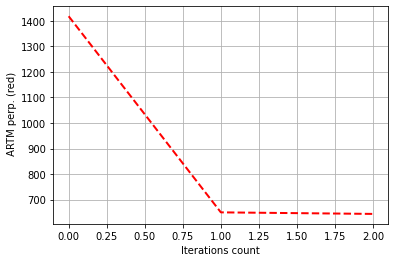

In [102]:
# посмотрим, что стало с моделью
# если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
# (не добавляя другие регуляризаторы)
print_measures(first_model_artm)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.021 (ARTM)
Kernel purity: 0.007 (ARTM)
Perplexity: 649.882 (ARTM)


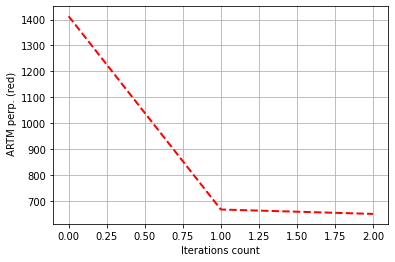

In [103]:
print_measures(second_model_artm)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.040 (ARTM)
Kernel purity: 0.001 (ARTM)
Perplexity: 641.116 (ARTM)


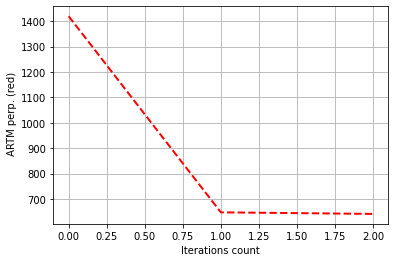

In [104]:
print_measures(third_model_artm)

Добавим регуляризаторы разреженности тем и документов.

Их рекомендуется добавлять после того, как модель уже как-то сошлась. После добавления их рекомендуется постепенно уменьшать, чтобы усиливать разреживание. Их можно применять не ко всем темам, чтобы в каких-то темах собрались все стоп-слова.

Можно добавлять их вместе или по отдельности.

In [106]:
models = [first_model_artm, second_model_artm, third_model_artm]
topics = [100, 200, 100]
for index in range(len(models)):
    models[index].regularizers.add(artm.SmoothSparsePhiRegularizer(
        name='SparsePhi',
        tau=-0.20,
        topic_names=[f'topic_{i}' for i in range(1, topics[index])]))
    models[index].regularizers.add(artm.SmoothSparseThetaRegularizer(
        name='SparseTheta',
        tau=-0.20,
        topic_names=['topic_{}'.format(i) for i in range(1, topics[index])]))

In [107]:
for model in models:
    model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

In [108]:
# будем постепенно увеличивать значения этих регуляризаторов
for model in models:
    phi_tau = model.regularizers['SparsePhi'].tau
    theta_tau = model.regularizers['SparseTheta'].tau

    for i in range(10):
        model.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.6))
        model.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.15))
        
        model.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)
    

Sparsity Phi: 0.905 ARTM)
Sparsity Theta: 0.765 (ARTM)
Kernel contrast: 0.416 (ARTM)
Kernel purity: 0.645 (ARTM)
Perplexity: 225.495 (ARTM)


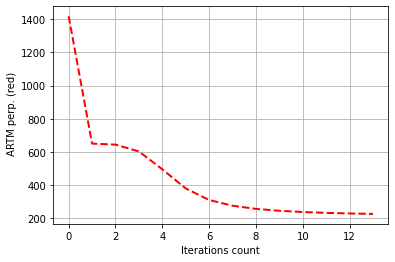

In [109]:
# посмотрим на качество
print_measures(first_model_artm)

Sparsity Phi: 0.924 ARTM)
Sparsity Theta: 0.879 (ARTM)
Kernel contrast: 0.386 (ARTM)
Kernel purity: 0.563 (ARTM)
Perplexity: 182.892 (ARTM)


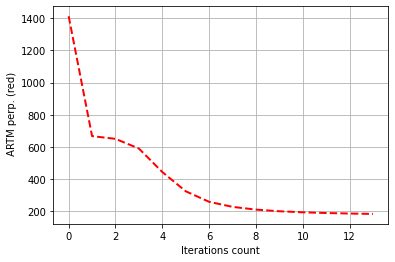

In [110]:
print_measures(second_model_artm)

Sparsity Phi: 0.924 ARTM)
Sparsity Theta: 0.729 (ARTM)
Kernel contrast: 0.465 (ARTM)
Kernel purity: 0.678 (ARTM)
Perplexity: 232.471 (ARTM)


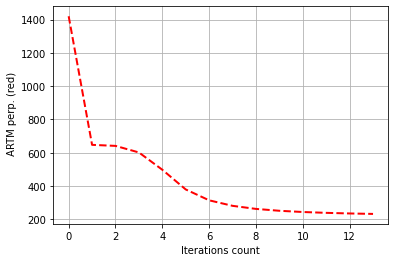

In [111]:
print_measures(third_model_artm)

#### По результатам обучения наилучшие значения показывает вторая модель. Проделаем ещё несколько итераций.

In [112]:
phi_tau = second_model_artm.regularizers['SparsePhi'].tau
theta_tau = second_model_artm.regularizers['SparseTheta'].tau
for i in range(6):
    second_model_artm.regularizers['SparsePhi'].tau = phi_tau * 1.4
    second_model_artm.regularizers['SparseTheta'].tau = theta_tau * 0.25
    second_model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=2)

# Итоги

Sparsity Phi: 0.953 ARTM)
Sparsity Theta: 0.822 (ARTM)
Kernel contrast: 0.447 (ARTM)
Kernel purity: 0.725 (ARTM)
Perplexity: 173.714 (ARTM)


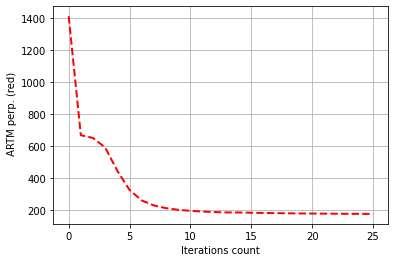

In [113]:
print_measures(second_model_artm)

In [ ]:
for topic_name in second_model_artm.topic_names[:50]:
    print('BEGIN TOPIC')
    print(topic_name + ': ')
    try:
        for x in second_model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('END TOPIC')
    
    except KeyError:
        continue

In [ ]:
"""
BEGIN TOPIC
topic_20: 
компания
банк
рынок
фирма
продажа
крупный
производитель
компьютер
процессор
корпорация
END TOPIC
BEGIN TOPIC
topic_30: 
право
закон
лицо
наказание
принять
законодательство
положение
ответственность
отношение
кодекс
END TOPIC
BEGIN TOPIC
topic_42: 
клуб
лига
выступать
команда
чемпионат
футбол
кубок
дивизион
футбольный_клуб
футбольный
END TOPIC
"""

Вторая модель: выбранное число топиков - 200. При инициализации попеременно добавлялись два декоррелятора с тау 0.3 и два фи-регуляризатора с тау 0.1. 

После двух итераций были добавлены фи- и тета-регуляризатор с параметрами тета -0.2.
Модель достигла перплексии 200 за 10 итераций, при которых параметры добавочных регуляризаторов менялись на 0.6 и 0.15 соответственно. 

После ещё шести итераций с двойным проходом по документам, на которых параметры добавочных регуляризаторов менялись на 1.4 для фи-регуляризатора и на 0.25 для тета-регуляризатора, перплексия достигла значения 172.


На последних итерациях значительно выросли параметры Kernel contrast и Kernel Purity.
